# ELMO - Evaluating Leaks for the ARM Cortex-M0

> ELMO is a power trace simulator that is able to simulate power traces for any given Thumb binary. 
> The source code is available online at https://github.com/bristol-sca/ELMO.

## How to record traces?

In order to run code with ELMO several special functions are provided to access meta functionality inside your code.
They are defined [here](../capture/elmo/elmoasmfunctionsdef.h) or [here](https://github.com/sca-research/ELMO/blob/master/Examples/elmoasmfunctionsdef.h).

### Triggering

- `void starttrigger(void)`
- `void endtrigger(void)`
- `void endprogram(void)`

In contrast to e.g. ChipWhisperer the control and execution of the victim code has to be part of the program itself.
This holds also true for the number of traces to be recorded!
A typical program looks like this:

```c
#define NUMBER_OF_TRACES 100

for (int i = 0; i < NUMBER_OF_TRACES; i++)
{
    starttrigger();
    victim_code();
    endtrigger();
}

endprogram();
```

### Reading input data

- `void readbyte(unsigned char *pointer)`

Input data has to be provided by a text file containing one byte in hex-notation per line. 
The location and name of the text file is compiled into elmo.

### Generating random

- `void randbyte(unsigned char *pointer)`

Random data cannot be set from outside.
It is directly generated in elmo using `rand()` from C-stdlib.

### Compiling the program

The most suitable approach was reuse one of elmo's example projects.
Several ingredients were needed:
- A Makefile
- `elmoasmfunctions`
- A linker file
- A vectors object file

🤷🏼‍♂️


### Trace output format

If `BINARYTRACES` is defined the traces are generated as array of `double`s.
The author used `struct.unpack("d", ...)` to read in python.

## Assembly trace

Beside the actual power trace a text file is generated which maps each trace point to the executed instruction.

## Power Model

ELMO supports 2 different power models:

- Hamming Weight/Hamming Distance
- ELMO

Detailed information about the models can be found in their paper.

## Limitations

Be aware that some instructions are not profiled at all!
TODO: More information needed.

## Example

How does a elmo generated trace look like?

In [1]:
%load_ext autoreload
%autoreload 2

import lascar
import matplotlib.pyplot as plt

import datasets

lascar.logger.setLevel(lascar.logging.CRITICAL)
plt.rcParams['figure.figsize'] = [15.0, 4.0]
plt.rcParams['figure.dpi'] = 140


[]

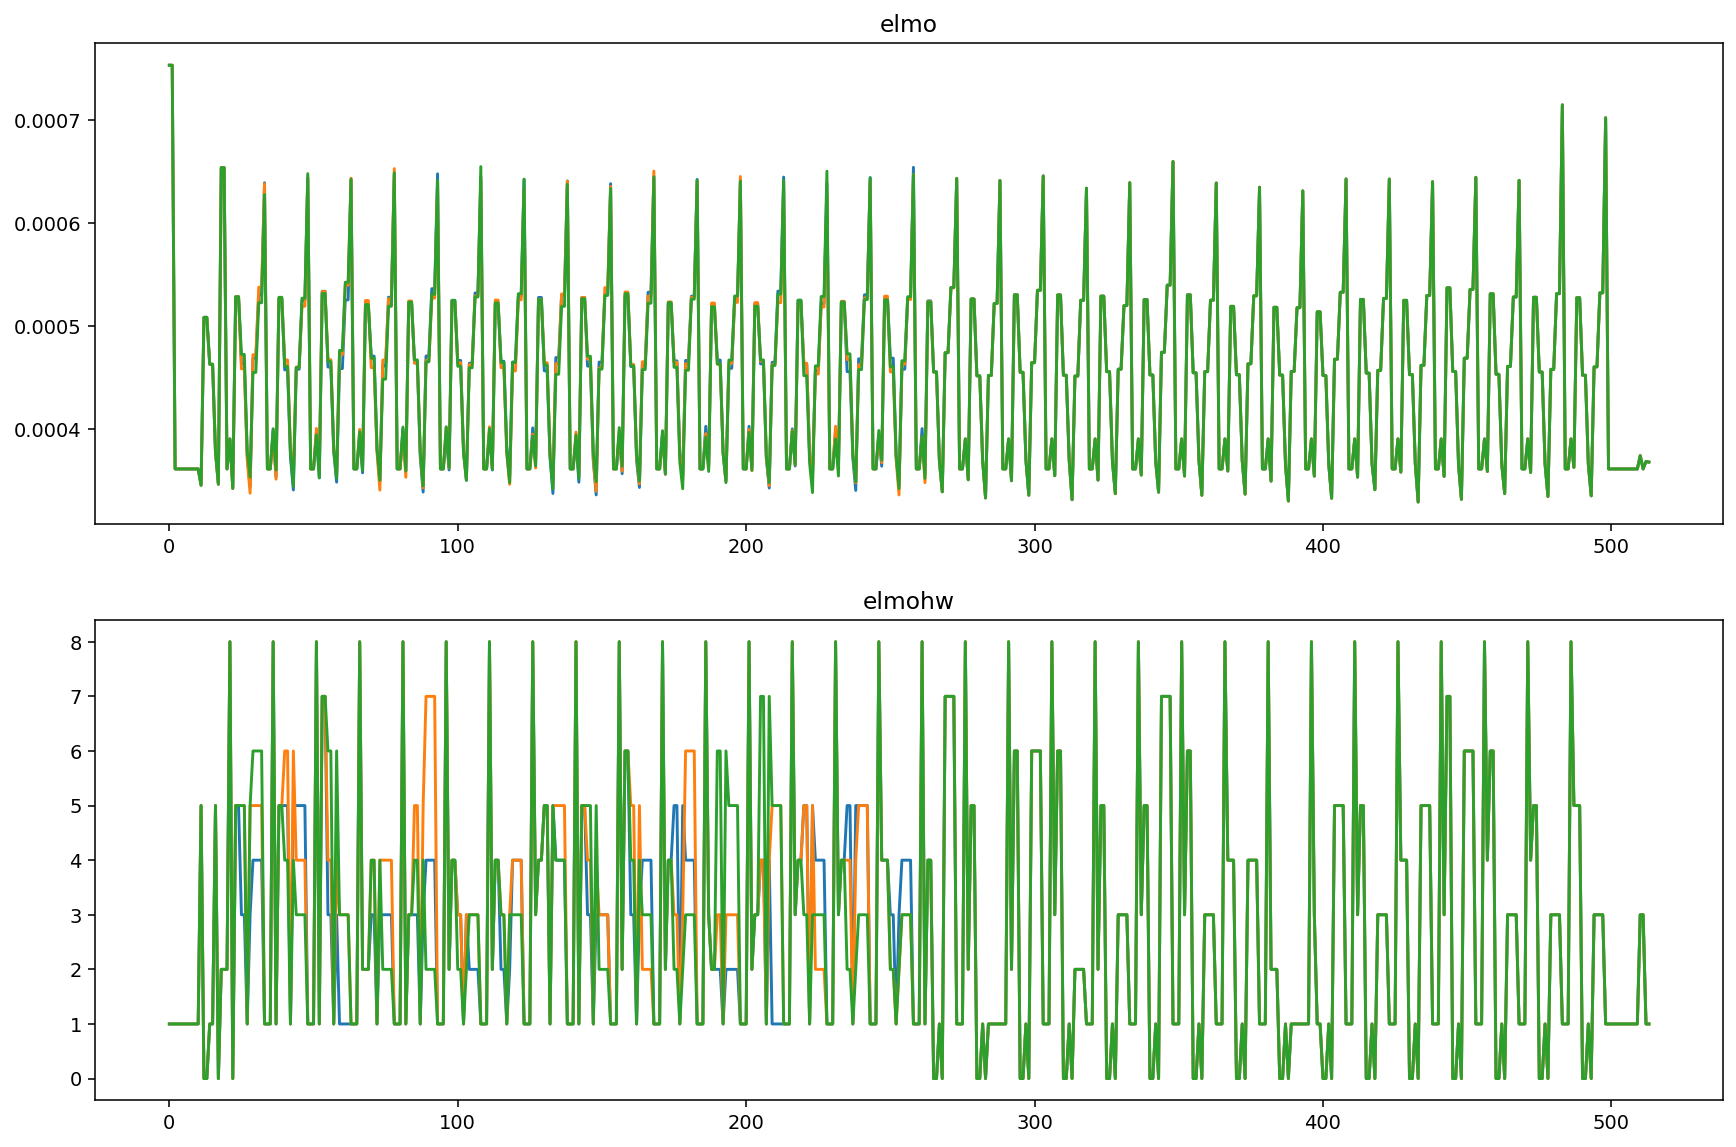

In [2]:
_, axes = plt.subplots(2, 1)
for i, model in enumerate(("elmo", "elmohw")):
    trace = datasets.dataset(f"{model}_plain_fixedkey")
    axes[i].plot(trace["trace"][0])
    axes[i].plot(trace["trace"][1])
    axes[i].plot(trace["trace"][2])
    axes[i].set_title(model)
    axes[i].figure.set_size_inches(15, 10)

plt.plot()


# CPA key recovery on ELMO traces

In [3]:
from leakage_detection_loop import cpa_full

/home/stefan/work/HSA/securec-sidechannel-study/.env/lib/python3.10/site-packages/lascar/engine/cpa_engine.py:79: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt(


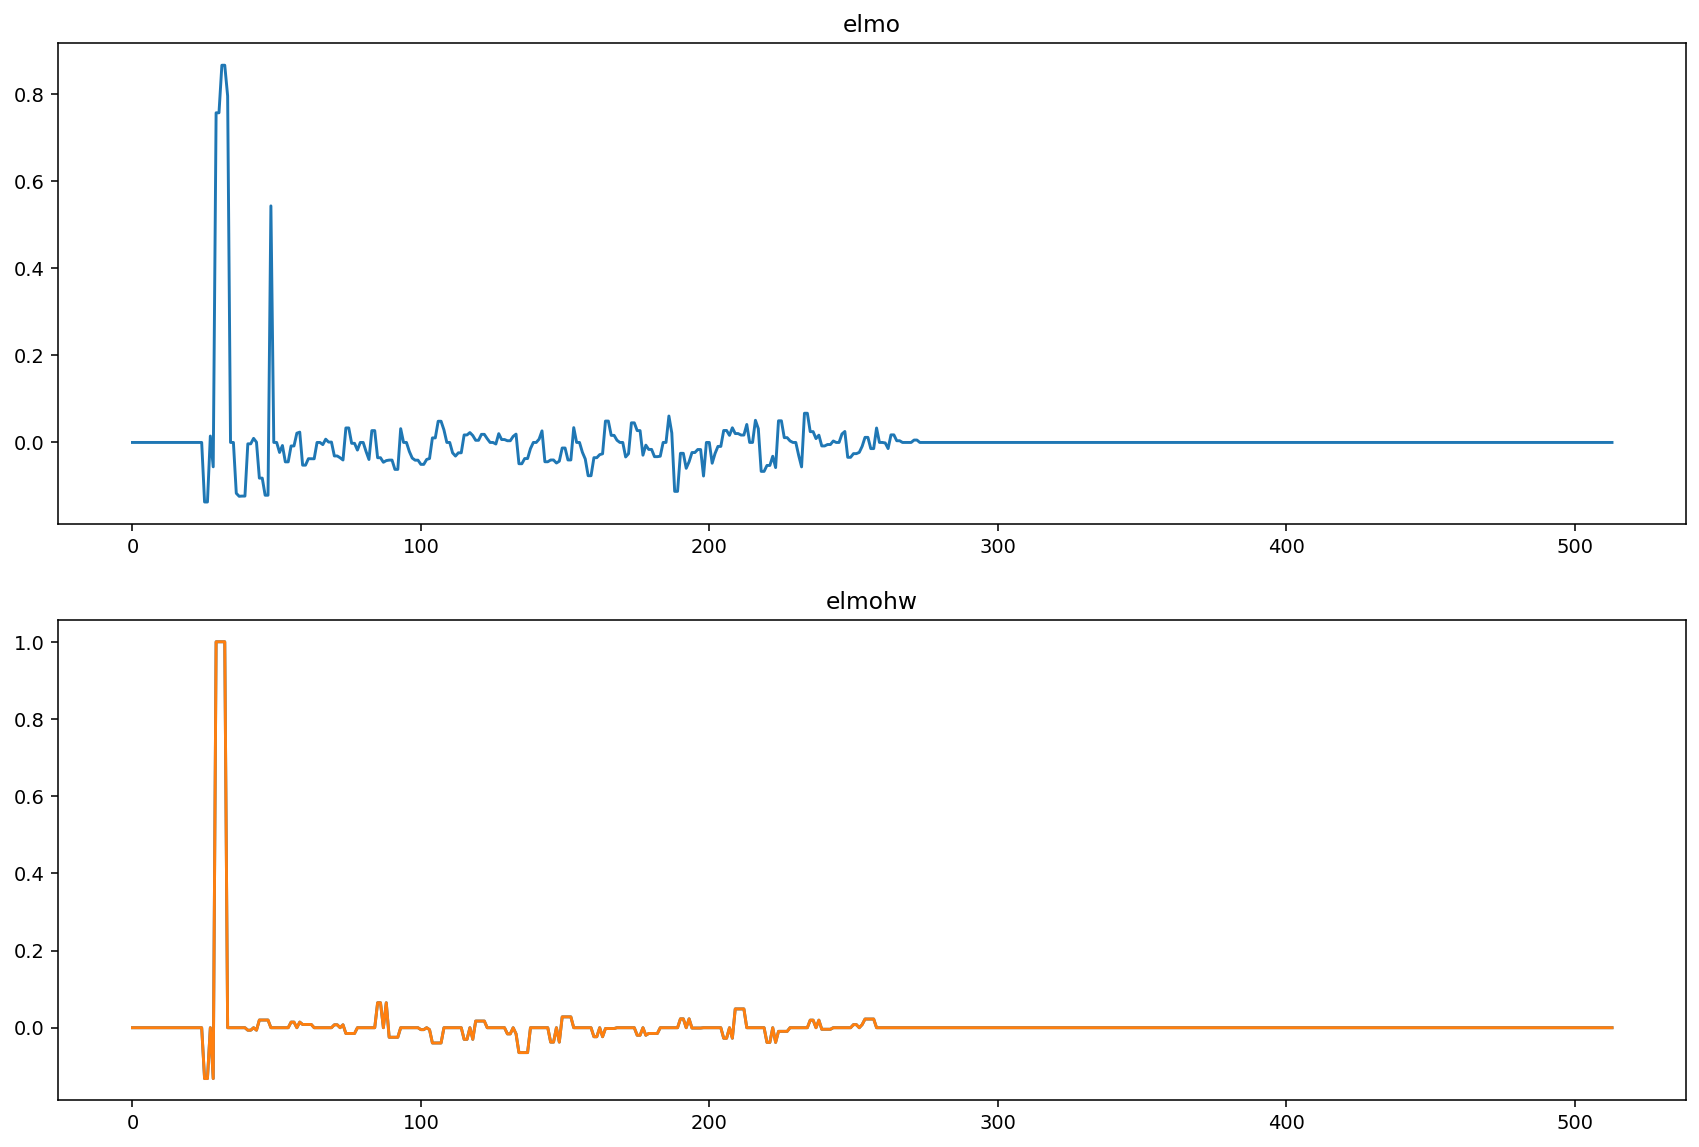

In [4]:
_, axes = plt.subplots(2, 1)
for i, model in enumerate(("elmo", "elmohw")):
    data = cpa_full(
        dataset=datasets.dataset(f"{model}_plain_fixedkey"),
        selection_function=lambda value, guess: lascar.hamming(lascar.tools.aes.sbox[value["input"][0] ^ value["key"][0]]),
        guess_range=range(1),
    )
    axes[i].plot(data)
    axes[i].set_title(model)
    axes[i].figure.set_size_inches(15, 10)
    # axes[i].set_xlim((25, 35))

plt.plot(data)
plt.show()

There is one cool thing now!
We clearly can say _which_ instruction(s) has/have generated the leakage.

By zooming in (uncomment setting of xlimit in aboves cell ;-) ) we can see that main leakage is present for Samples 29, 30, 31, 32.

`ASMOUTPUTFOLDER` and `ASMOUTPUTFILE` define the location of the assembly trace.
We can extract the necessary information there:

```asm
--- 0x080001DE: 0x5C61 ldrb r1,[r4,r1]
--- 0x080001DE: 0x5C61 ldrb r1,[r4,r1]
--- 0x080001E0: 0x54A9 strb r1,[r5,r2]
--- 0x080001E0: 0x54A9 strb r1,[r5,r2]
```

Note that in the ELMO power model sample 33 has also leakage information.


### Full Ranking

In [5]:
import key_recovery_loop

/home/stefan/work/HSA/securec-sidechannel-study/.env/lib/python3.10/site-packages/lascar/engine/cpa_engine.py:79: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt(
/home/stefan/work/HSA/securec-sidechannel-study/.env/lib/python3.10/site-packages/lascar/engine/cpa_engine.py:79: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt(
/home/stefan/work/HSA/securec-sidechannel-study/.env/lib/python3.10/site-packages/lascar/engine/cpa_engine.py:79: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt(
/home/stefan/work/HSA/securec-sidechannel-study/.env/lib/python3.10/site-packages/lascar/engine/cpa_engine.py:79: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt(
/home/stefan/work/HSA/securec-sidechannel-study/.env/lib/python3.10/site-packages/lascar/engine/cpa_engine.py:79: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt(


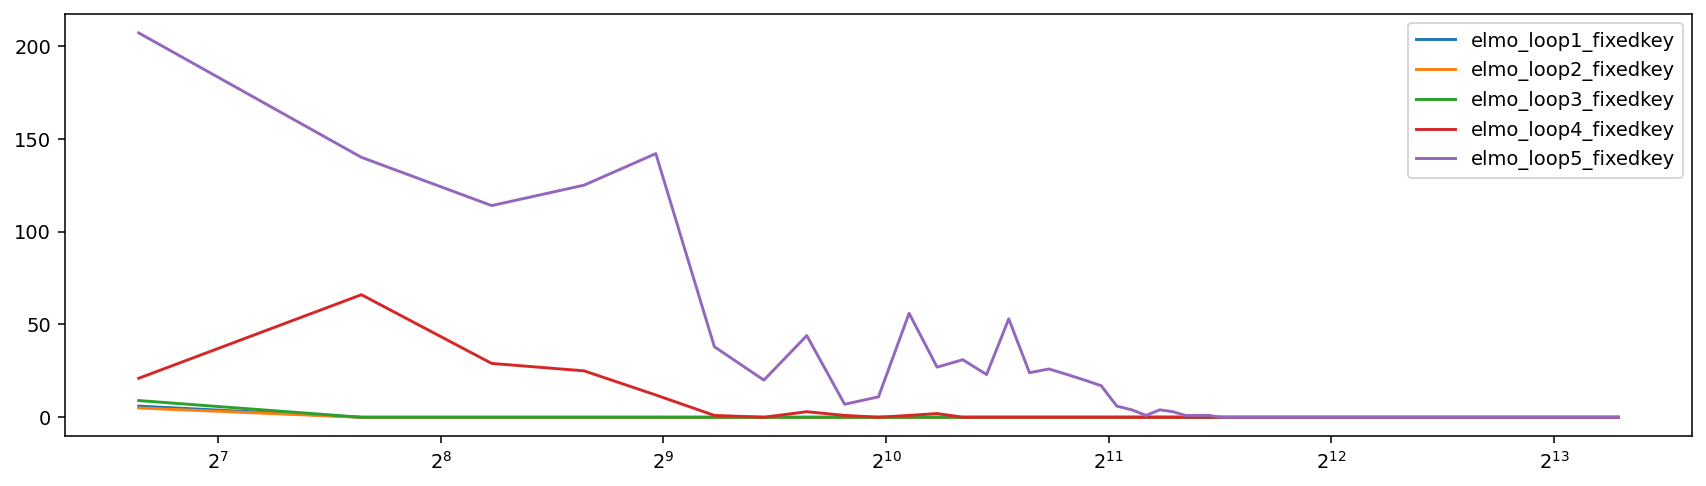

In [6]:
results = {
    dataset: key_recovery_loop.cpa(
        dataset=datasets.dataset(dataset),
        selection_function=lambda value, guess: lascar.hamming(lascar.tools.aes.sbox[value[2] ^ guess]),
        correct_key=datasets.dataset(dataset)[0]["key"][2],
    )
    for dataset in (
        "elmo_loop1_fixedkey",
        "elmo_loop2_fixedkey",
        "elmo_loop3_fixedkey",
        "elmo_loop4_fixedkey",
        "elmo_loop5_fixedkey",
    )
}

for name, result in results.items():
    plt.plot(*zip(*result), label=name)

plt.legend()
plt.xscale("log", base=2)
plt.show()

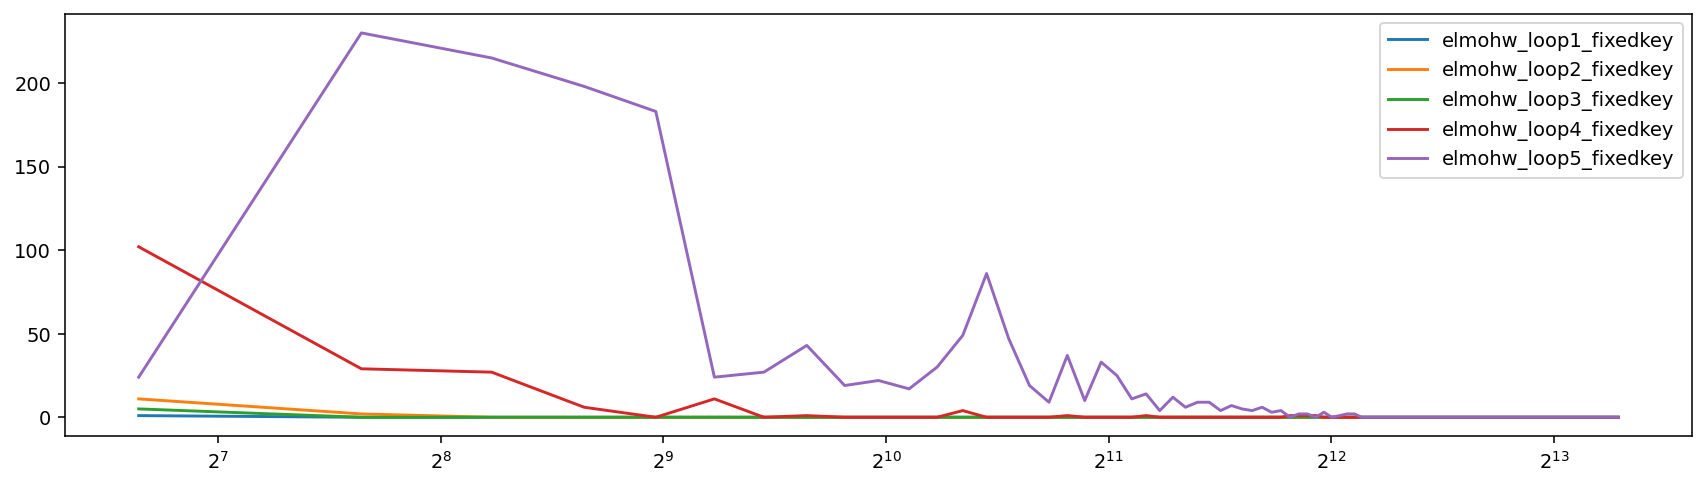

In [7]:
results = {
    dataset: key_recovery_loop.cpa(
        dataset=datasets.dataset(dataset),
        selection_function=lambda value, guess: lascar.hamming(lascar.tools.aes.sbox[value[2] ^ guess]),
        correct_key=datasets.dataset(dataset)[0]["key"][2],
    )
    for dataset in (
        "elmohw_loop1_fixedkey",
        "elmohw_loop2_fixedkey",
        "elmohw_loop3_fixedkey",
        "elmohw_loop4_fixedkey",
        "elmohw_loop5_fixedkey",
    )
}

for name, result in results.items():
    plt.plot(*zip(*result), label=name)

plt.legend()
plt.xscale("log", base=2)
plt.show()


## Leakage Detection with ELMO

In [8]:
import leakage_detection_loop
from leakage_detection_loop import njit

/home/stefan/work/HSA/securec-sidechannel-study/.env/lib/python3.10/site-packages/lascar/engine/cpa_engine.py:79: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt(


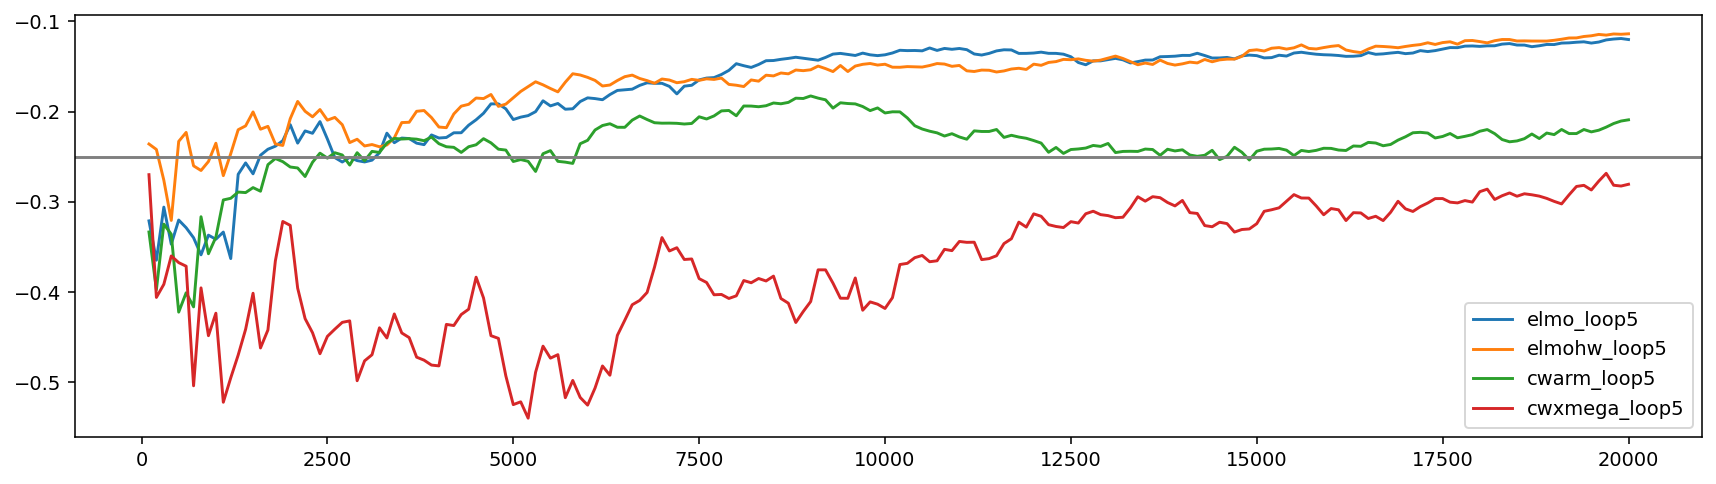

In [9]:
for name in ["elmo_loop5", "elmohw_loop5", "cwarm_loop5", "cwxmega_loop5"]:
    clr = leakage_detection_loop.cpa_leakage_rate(
        dataset=datasets.dataset(f"{name}_randomkey_randominput"),
        selection_function=njit()(
            lambda value: lascar.hamming(lascar.tools.aes.sbox[value["input"][2] ^ value["key"][2]])
        ),
    )
    plt.plot(*zip(*clr), label=name)

plt.axhline(-0.25, color="gray")
plt.legend()
plt.show()

